In [1]:
from rdkit import Chem
from cgr.draw import draw_molecule
from cgr.cheminfo import calc_molecule_rcmcs
from IPython.display import SVG
from cgr.filepaths import filepaths
import json
import numpy as np
from cgr.cheminfo import MorganFingerprinter
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}

In [3]:
# From the decarb bottle case study

rids = [
    '1162',
    '10184',
    '15374',
    '17157'
]

smiles = []
mols = []
rcs = []
for rid in rids:
    smi = decarb[rid]['smarts'].split('>>')[0]
    mol = Chem.MolFromSmiles(smi)
    rc = decarb[rid]['reaction_center'][0]

    smiles.append(smi)
    mols.append(mol)
    rcs.append(rc)



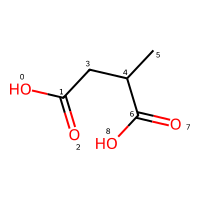

In [4]:
pred_smi = 'OC(=O)CC(C)C(=O)O'
pred_mol = Chem.MolFromSmiles(pred_smi)
display(SVG(draw_molecule(pred_mol, draw_options={'addAtomIndices': True})))

In [5]:
pred_rc = [0, 1, 3]

smiles.append(pred_smi)
mols.append(pred_mol)
rcs.append(pred_rc)

NC(CC(=O)O)C(=O)O


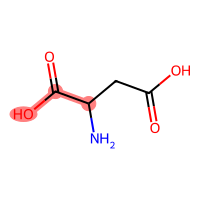

O=C(O)C(O)C(O)C(=O)O


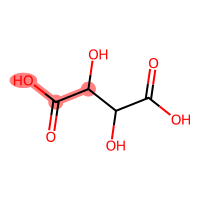

O=C(O)CC(O)C(=O)O


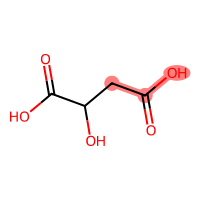

NC(CC(=O)O)C(=O)O


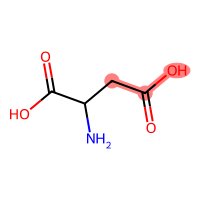

OC(=O)CC(C)C(=O)O


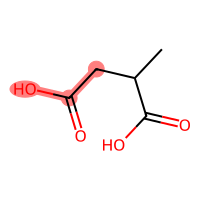

In [6]:
for smi, mol, rc in zip(smiles, mols, rcs):
    print(smi)
    display(SVG(draw_molecule(mol, hilite_atoms=rc)))

In [7]:
patt = '[#6:1]-[#6:2]-[#8:3]'

rc_sims = {}
for i in range(len(smiles) - 1):
    for j in range(i + 1, len(smiles)):
        key = (i, j)
        arg1 = (mols[i], rcs[i])
        arg2 = (mols[j], rcs[j])
        sim = calc_molecule_rcmcs(arg1, arg2, patt)
        rc_sims[key] = sim

In [8]:
rc_sims

{(0, 1): 0.8,
 (0, 2): 0.8888888888888888,
 (0, 3): 0.8888888888888888,
 (0, 4): 0.8888888888888888,
 (1, 2): 0.9,
 (1, 3): 0.8,
 (1, 4): 0.8,
 (2, 3): 0.8888888888888888,
 (2, 4): 0.8888888888888888,
 (3, 4): 0.8888888888888888}

In [31]:
radius = 3
length = 2**12
mfper = MorganFingerprinter(radius=radius, length=length)
rc_dist_ub = 0

mols = [Chem.MolFromSmiles(smi) for smi in smiles]

M = [] # Trad morgan
L = [] # w/ location info
R = [] # w/ loc info and rooted at peri-rc substructure

query_M = []
query_L = []
query_R = []

for smi, mol, rc in zip(smiles, mols, rcs):
    query_M.append(mfper.fingerprint(mol))
    query_L.append(mfper.fingerprint(mol, reaction_center=rc))
    query_R.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))

for key, rxn in decarb.items():
    rc = rxn['reaction_center'][0]
    smi = rxn['smarts'].split('>>')[0]
    mol = Chem.MolFromSmiles(smi)
    M.append(mfper.fingerprint(mol))
    L.append(mfper.fingerprint(mol, reaction_center=rc))
    R.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))

M = np.vstack(M)
L = np.vstack(L)
R = np.vstack(R)
query_M = np.vstack(query_M)
query_L = np.vstack(query_L)
query_R = np.vstack(query_R)

tmp = []
for q_mat, bank_mat in zip([query_M, query_L, query_R], [M, L, R]):
    mat = np.vstack((q_mat, bank_mat))
    c = mat.sum(axis=1) # Cardinality
    D = np.matmul(mat, mat.T)
    T = D / (c.reshape(1, -1) + c.reshape(-1, 1) - D) # Tanimoto similarity
    tmp.append(T[:5, 5:])

Sm, Sl, Sr = tmp

patt = '[#6:1]-[#6:2]-[#8:3]'

Sc = np.zeros_like(Sm) # RCMCS sim
for i, q_smi in enumerate(smiles):
    for j, (key, rxn) in enumerate(decarb.items()):
        bank_rc = rxn['reaction_center'][0]
        bank_smi = rxn['smarts'].split('>>')[0]
        bank_mol = Chem.MolFromSmiles(bank_smi)
        q_mol = Chem.MolFromSmiles(q_smi)
        arg1 = (q_mol, rcs[i])
        arg2 = (bank_mol, bank_rc)
        sim = calc_molecule_rcmcs(arg1, arg2, patt)
        Sc[i, j] = sim

In [32]:
opts = np.arange(Sm.shape[0])
sim_mats = {
    'traditional': Sm,
    'location': Sl,
    'location_rooted': Sr,
    'rcmcs': Sc
}
stopts = list(sim_mats.keys())

@interact
def rank_by_one(
    query = widgets.Dropdown(value=opts[0], options=opts),
    sim_type = widgets.Dropdown(value=stopts[0], options=stopts),
    topk: int = 10
):    

    bank_keys = list(decarb.keys())
    sim_row = sim_mats[sim_type][query, :]
    srt_idxs = np.argsort(sim_row)[::-1]

    print("Query")
    display(SVG(draw_molecule(mols[query], hilite_atoms=rcs[query], size=(400, 250))))
    print('-' * 50)

    for i, idx in enumerate(srt_idxs):
        k = bank_keys[idx]
        sim = sim_row[idx]
        print(f"ID: {k}")
        print(f"Similarity score: {sim}")
        rxn = decarb[k]
        rc = rxn['reaction_center'][0]
        smi = rxn['smarts'].split('>>')[0]
        display(SVG(draw_molecule(smi, hilite_atoms=rc, size=(300, 200))))

        if i > topk:
            break

interactive(children=(Dropdown(description='query', options=(np.int64(0), np.int64(1), np.int64(2), np.int64(3…

In [29]:
sim_row = sim_mats['location'][0, :]
srt_idxs = np.argsort(sim_row)[::-1]
sim_row[srt_idxs]

array([1.        , 0.46666667, 0.46666667, 0.46153846, 0.44444444,
       0.4       , 0.36363636, 0.35294118, 0.35294118, 0.34285714,
       0.33333333, 0.32432432, 0.30769231, 0.30769231, 0.3       ,
       0.29411765, 0.29411765, 0.29411765, 0.29268293, 0.28571429,
       0.27906977, 0.26666667, 0.26086957, 0.23809524, 0.23529412,
       0.225     , 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.21276596, 0.21276596, 0.21052632, 0.19512195, 0.19117647,
       0.18461538, 0.18181818, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16216216, 0.16129032, 0.16049383,
       0.15555556, 0.15384615, 0.15      , 0.14814815, 0.14705882,
       0.14705882, 0.14634146, 0.14285714, 0.14285714, 0.14      ,
       0.13953488, 0.13636364, 0.13333333, 0.13333333, 0.13157895,
       0.13157895, 0.13157895, 0.12820513, 0.12765957, 0.12195122,
       0.11904762, 0.11627907, 0.11627907, 0.11538462, 0.11363636,
       0.10526316, 0.1       , 0.0952381 , 0.09433962, 0.09259